## Horses v/s Humans

<br>

The following will be done in the notebook for the [Horses_humans_dataset](https://www.tensorflow.org/datasets/catalog/horses_or_humans):
- Build and train model for the horses and humans dataset. This has over thousand images of horses and humans with varying poses and filesizes.
- Preprocess the images using the `image_dataset_from_directory` utility
- Use the `Rescaling` layer to normalize the images
- Chain different methods of the `tf.data.Dataset` to configure it for performance

Final testing includes adding images from the internet to see how the model performs on them

In [13]:
# Import libraries
import tensorflow as tf
import numpy as np
import os
from io import BytesIO
import random

# Plotting images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from jupyterthemes import jtplot

# Interactive widgets
from ipywidgets import widgets

### Steps to import dataset

1. Download the horses humans training set from this [URL](https://storage.googleapis.com/learning-datasets/horse-or-human.zip)
2. Unzip the dataset onto your local system
3. Pass the main directory's path to the `tf.keras.utils.image_dataset_from_directory` as the training directory

In [2]:
# Check the contents of the dataset

training_dir = 'horse-or-human'

print(f"Files the the current directory: {os.listdir()}")
print(f"\nSubdirectories within '{training_dir}' dir: {os.listdir(training_dir)}")

Files the the current directory: ['.DS_Store', 'Digits MNIST (CNNs).ipynb', 'Fashion MNIST (CNNs).ipynb', 'Fashion MNIST.ipynb', 'Playground.ipynb', 'Digits MNIST.ipynb', '.ipynb_checkpoints', 'Horses vs Humans.ipynb', 'horse-or-human']

Subdirectories within 'horse-or-human' dir: ['humans', 'horses']


### Data preprocessing

Using the `image_from_dataset_directory` utility to read pictures in the source folders. This will use the directory to output an object of type `tf.data.dataset`. <br>
The tf.data API is optimized for parallel processing such as feeding data to GPUs and TPUs. This makes training faster

In [3]:
train_dataset = tf.keras.utils.image_dataset_from_directory(training_dir, 
                                                            image_size=(300, 300), 
                                                            batch_size=32, 
                                                            label_mode='binary')

dataset_type = type(train_dataset)
print(f'train_dataset inherits from tf.data.Dataset: {issubclass(dataset_type, tf.data.Dataset)}')

Found 1027 files belonging to 2 classes.
train_dataset inherits from tf.data.Dataset: True


2025-06-15 15:27:26.671067: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Pro
2025-06-15 15:27:26.671100: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-06-15 15:27:26.671104: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
I0000 00:00:1749981446.671117 11365658 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1749981446.671146 11365658 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


#### Checking the dataset shapes and dimensions
Here the `.take()` method fetches _*2 batches*_ of images from the dataset (batch size = 32)<br>

    sample_batch: Second batch from the 2 batches (32 images from 64)
    sample_batch[0]: List/batch of all images
    sample_batch[1]: List/batch of all labels
    image_batch[0]: Single image
    label_batch[0]: Single label

In [4]:
# Inspect the data and size of images
sample_batch = list(train_dataset.take(2))[1]

# Check that the output is a pair
print(f"Sample batch datatype: {type(sample_batch)}")
print(f"Number of elements: {len(sample_batch)}")

# Extract the image and label
image_batch = sample_batch[0]
label_batch = sample_batch[1]

print(f"\nImage shape: {image_batch.shape}")
print(f"Labels shape: {label_batch.shape}")

# Check the maximum and minimum values for the pixels
print(f"\nMax pixel value: {np.max(image_batch[0].numpy())}")
print(f"Min pixel value: {np.min(image_batch[0].numpy())}")

Sample batch datatype: <class 'tuple'>
Number of elements: 2

Image shape: (32, 300, 300, 3)
Labels shape: (32, 1)

Max pixel value: 255.0
Min pixel value: 6.0


2025-06-15 15:27:26.844727: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Normalize the images
Use the `tf.keras.layers.Rescaling` from tensorflow to normalize the images into a range from [0,1]

In [5]:
# Create the rescaling layer
normalization_layer = tf.keras.layers.Rescaling(scale=1./255)

# Normalize the image
image_scaled = normalization_layer(image_batch[0].numpy())
print(f"Max pixel value in scaled image: {np.max(image_scaled)}")
print(f"Min pixel value in scaled image: {np.min(image_scaled)}")

Max pixel value in scaled image: 1.0
Min pixel value in scaled image: 0.02352941408753395


#### Normalize the complete dataset
Write a function which uses the `normalization_layer` and returns the normalized image and label

In [6]:
# Function to normalize an image
def normalize_image(image, label):
    return normalization_layer(image), label

train_dataset_scaled = train_dataset.map(normalize_image)

In [7]:
# Check the image size for elements in scaled dataset
sample_batch = list(train_dataset_scaled.take(2))[1]
image_scaled = sample_batch[0][5].numpy()

print(f"Max pixel value: {np.max(image_scaled)}")
print(f"Min pixel value: {np.min(image_scaled)}")

Max pixel value: 1.0
Min pixel value: 0.019607843831181526


2025-06-15 15:27:26.977712: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Preprocessing the normalized data


    1. cache(): Stores elements in memory for faster retrieval the next time
    2. shuffle(): Randomly shuffles the dataset. Buffer size of 1000 means it will first select 
                  a sample from the first 1,000 elements, then keep filling this buffer
                  until all elements have been selected.
    
    3. prefetch(): Gets elements while the model is training so it's faster to feed in new data when 
                   the current training step is finished. A buffer_size set to tf.data.AUTOTUNE dynamically sets
                   the number of elements to prefetch during runtime.
    
cache() and prefetch() help in _*reducing the training time*_

In [8]:
# Generate the final training dataset
train_dataset_final = (train_dataset
                       .cache()
                       .shuffle(1000)
                       .prefetch(tf.data.AUTOTUNE))

### Modelling

1. Define the model layers and check the model summary
2. Compile the model with the optimizers
3. Define an early stopping callback if any
4. Train the model on the dataset

In [9]:
model = tf.keras.Sequential([
    tf.keras.Input(shape=(300, 300, 3)),
    tf.keras.layers.Conv2D(16, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Second convolution
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Third convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fourth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Fifth convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     1,606,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,704,097 (6.50 MB)

 Trainable params: 1,704,097 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [11]:
# Train the model on the tf.data.dataset preprocessed above
model_training_history = model.fit(
    train_dataset_final,
    epochs=15,
    verbose=2
)

Epoch 1/15


2025-06-15 15:27:27.520263: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


33/33 - 4s - 124ms/step - accuracy: 0.5258 - loss: 47.7576
Epoch 2/15
33/33 - 2s - 64ms/step - accuracy: 0.6631 - loss: 6.5009
Epoch 3/15
33/33 - 2s - 63ms/step - accuracy: 0.9075 - loss: 0.2987
Epoch 4/15
33/33 - 2s - 63ms/step - accuracy: 0.8802 - loss: 0.5223
Epoch 5/15
33/33 - 2s - 63ms/step - accuracy: 0.8277 - loss: 12.2985
Epoch 6/15
33/33 - 2s - 63ms/step - accuracy: 0.9056 - loss: 2.2725
Epoch 7/15
33/33 - 2s - 63ms/step - accuracy: 0.8978 - loss: 7.0801
Epoch 8/15
33/33 - 2s - 64ms/step - accuracy: 0.8880 - loss: 1.3794
Epoch 9/15
33/33 - 2s - 63ms/step - accuracy: 0.9464 - loss: 2.0542
Epoch 10/15
33/33 - 2s - 63ms/step - accuracy: 0.9591 - loss: 0.3299
Epoch 11/15
33/33 - 2s - 63ms/step - accuracy: 0.9484 - loss: 0.8049
Epoch 12/15
33/33 - 2s - 63ms/step - accuracy: 0.9659 - loss: 0.3690
Epoch 13/15
33/33 - 2s - 64ms/step - accuracy: 0.9513 - loss: 0.8492
Epoch 14/15
33/33 - 2s - 64ms/step - accuracy: 0.9747 - loss: 0.2814
Epoch 15/15
33/33 - 2s - 64ms/step - accuracy: 0.94

#### Plot the accuracy graph for every epoch

In [59]:
jtplot.style(context='talk', fscale=1, spines=False, gridlines='--')
jtplot.style(ticks=True, figsize=(10,6))

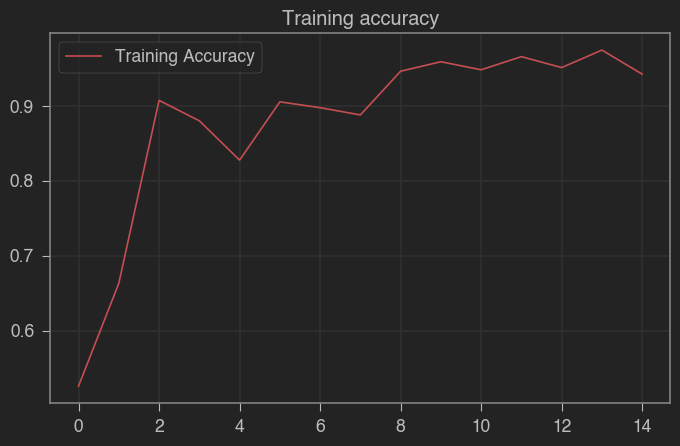

In [62]:
accuracy = model_training_history.history['accuracy']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'r', label='Training Accuracy')
plt.title('Training accuracy')
plt.legend(loc=0)
plt.show()

### Model prediction on custom images

In [71]:
uploader = widgets.FileUpload(accept="image/*", multiple=True)
display(uploader)
out = widgets.Output()
display(out)

# Function to make the prediction using the model
def file_predict(filename, file, out):
    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = normalization_layer(image)
    image = np.expand_dims(image, axis=0)
    
    prediction = model.predict(image)[0][0]
    with out:
        if prediction > 0.5:
            print(filename, "is a human")
        else:
            print(filename, "is a horse")
    

def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        file_predict(item.name, file_jpgdata, out)
        
        
uploader.observe(on_upload_change, names='value')
    

FileUpload(value=(), accept='image/*', description='Upload', multiple=True)

Output()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


### Visualizing Intermediate model representations

FileUpload(value=(), accept='image/*', description='Upload')

Output()

Its a HUMAN!


/var/folders/f2/j66wx7px7sx9qrws63ymk_sr0000gn/T/ipykernel_52821/3540247891.py:34: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
/var/folders/f2/j66wx7px7sx9qrws63ymk_sr0000gn/T/ipykernel_52821/3540247891.py:37: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


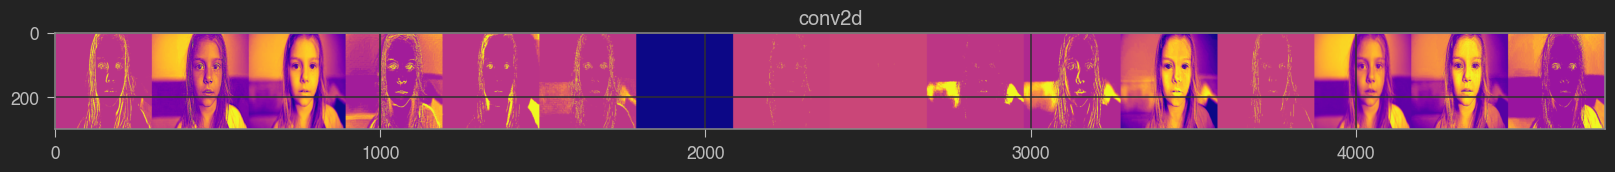

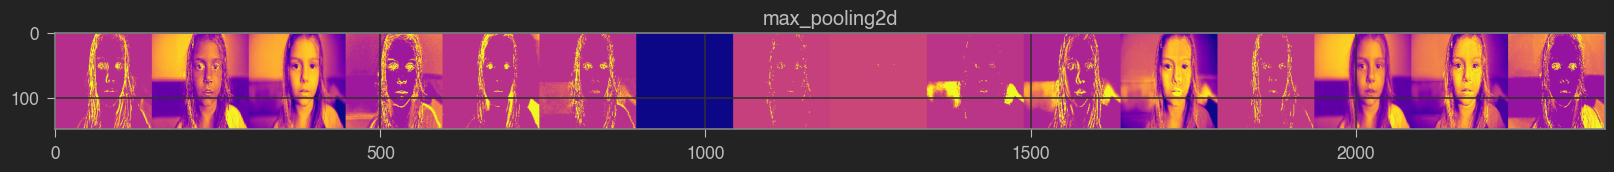

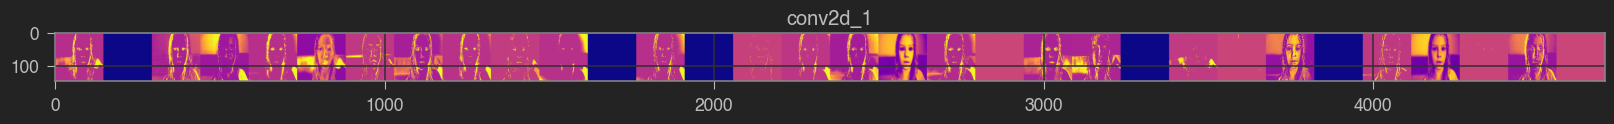

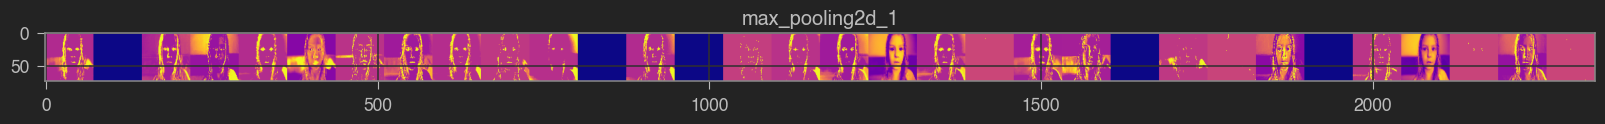

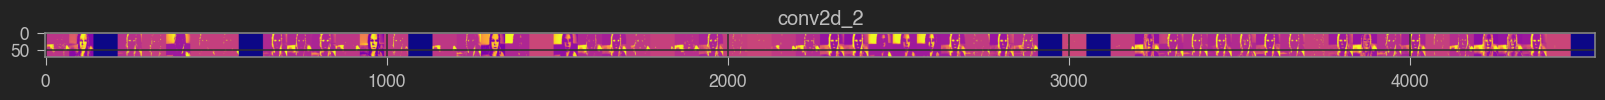

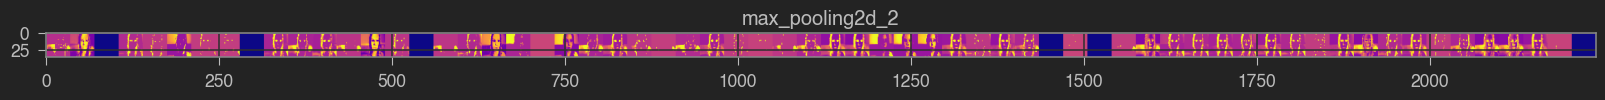

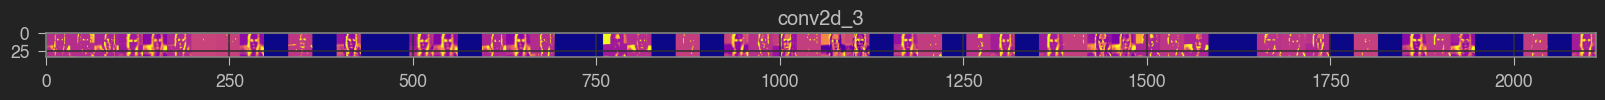

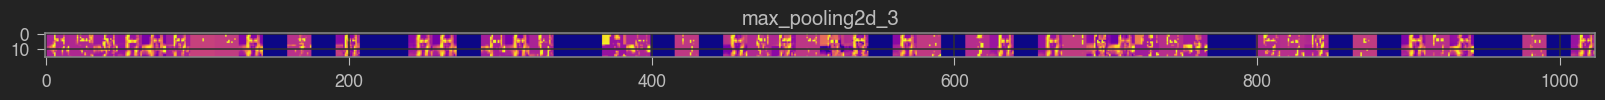

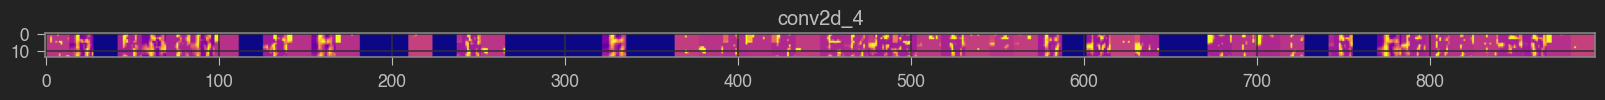

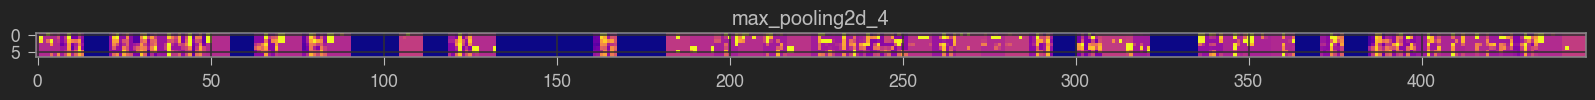

In [105]:
def visualize_model_predictions(file):
    # New model that outputs individual layer results
    successive_outputs = [layer.output for layer in model.layers[0:]]
    visualization_model = tf.keras.models.Model(inputs = model.inputs, outputs = successive_outputs)

    image = tf.keras.utils.load_img(file, target_size=(300, 300))
    image = tf.keras.utils.img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = normalization_layer(image)
    
    # Model predictions
    prediction = model.predict(image, verbose=0)
    successive_feature_maps = visualization_model.predict(image, verbose=False)
    if prediction > 0.5:
        print("Its a HUMAN!")
    else: print("Its a HORSE!")

    # Layer names
    layer_names = [layer.name for layer in model.layers[0:]]

    # Display the visual layer outputs
    for layer_name, feature_map in zip(layer_names, successive_feature_maps):
        if len(feature_map.shape) == 4:
            # Only for Conv and MaxPooling layers
            n_features = feature_map.shape[-1]

            # Feature map has the shape (1, size, size, n_features)
            size = feature_map.shape[1]

            display_grid = np.zeros((size, size*n_features))
            for i in range(n_features):
                x = feature_map[0,:,:,i]
                x -= x.mean()
                x /= x.std()
                x *= 64
                x += 128
                x = np.clip(x, 0, 255).astype('uint8')

                # Tile each filter into the big horizontal grid
                display_grid[:, i*size: (i+1)*size] = x

            # Display the grid
            scale = 20./n_features
            plt.figure(figsize=(scale*n_features, scale))
            plt.title(layer_name)
            plt.imshow(display_grid, aspect='auto', cmap='plasma')
            
            
def on_upload_change(change):
    """ A function for geting files from the widget and running the prediction."""    
    items = change.new
    for item in items: # Loop if there is more than one file uploaded  
        file_jpgdata = BytesIO(item.content)
        visualize_model_predictions(file_jpgdata)
        
uploader = widgets.FileUpload(accept="image/*", multiple=False)
display(uploader)
out = widgets.Output()
display(out)
uploader.observe(on_upload_change, names='value')